# Asteroid Classification: Predicting Whether an Asteroid is Potentially Hazardous or Not


> "Potentially Hazardous Asteroids (PHAs) are currently defined based on parameters that measure the asteroid’s potential to make threatening close approaches to the Earth. Specifically, **all asteroids with a minimum orbit intersection distance (MOID) of 0.05 au or less and an absolute magnitude (H) of 22.0 or less are considered PHAs**."
>https://cneos.jpl.nasa.gov/glossary/PHA.html#:~:text=Specifically%2C%20all%20asteroids%20with%20a,or%20less%20are%20considered%20PHAs.


This notebook discusses the other factors that might be useful to identify an asteroid as potentially hazardous or not. And explains the classification power of those remaining factors in the absence of absolute magnitude and minimum orbit intersection values.

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split 


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier
#from xgboost import plot_importance


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
# Load the dataset
data = pd.read_csv('nasa.csv')
data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


### Data Pre-Processing

In [3]:
print(data.shape)
print(data.info())

(4687, 40)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64

Dataset has no null values and contains the information about **4687 asteroids with 40 features**. 

In [4]:
# Missing value percentage
round((data.isnull().sum() * 100/ len(data)),2).sort_values(ascending=False)

Neo Reference ID                0.0
Name                            0.0
Orbit Determination Date        0.0
Orbit Uncertainity              0.0
Minimum Orbit Intersection      0.0
Jupiter Tisserand Invariant     0.0
Epoch Osculation                0.0
Eccentricity                    0.0
Semi Major Axis                 0.0
Inclination                     0.0
Asc Node Longitude              0.0
Orbital Period                  0.0
Perihelion Distance             0.0
Perihelion Arg                  0.0
Aphelion Dist                   0.0
Perihelion Time                 0.0
Mean Anomaly                    0.0
Mean Motion                     0.0
Equinox                         0.0
Orbit ID                        0.0
Orbiting Body                   0.0
Miss Dist.(miles)               0.0
Est Dia in Feet(min)            0.0
Absolute Magnitude              0.0
Est Dia in KM(min)              0.0
Est Dia in KM(max)              0.0
Est Dia in M(min)               0.0
Est Dia in M(max)           

In [5]:
# Unique values
data.nunique()

Neo Reference ID                3692
Name                            3692
Absolute Magnitude               269
Est Dia in KM(min)               269
Est Dia in KM(max)               269
Est Dia in M(min)                269
Est Dia in M(max)                269
Est Dia in Miles(min)            269
Est Dia in Miles(max)            269
Est Dia in Feet(min)             269
Est Dia in Feet(max)             269
Close Approach Date              777
Epoch Date Close Approach        777
Relative Velocity km per sec    4687
Relative Velocity km per hr     4687
Miles per hour                  4687
Miss Dist.(Astronomical)        4673
Miss Dist.(lunar)               4660
Miss Dist.(kilometers)          4661
Miss Dist.(miles)               4660
Orbiting Body                      1
Orbit ID                         188
Orbit Determination Date        2680
Orbit Uncertainity                10
Minimum Orbit Intersection      3678
Jupiter Tisserand Invariant     2495
Epoch Osculation                 429
E

Contain one value for all the data:
   - 'Orbiting Body'
   - 'Equinox' 
    
    
Contain some level of unique data or text data that are less interest.
   - 'Neo Reference ID'
   - 'Name'
   - 'Close Approach Date'
   - 'Epoch Date Close Approach'
   - 'Orbit ID'
   - 'Orbit Determination Date'
   - 'Epoch Osculation'
   - 'Perihelion Time' 
    
So, we can drop all these variables.

In [6]:
# drop the mentioned variables from the dataset
df = data.drop(['Orbiting Body','Equinox','Neo Reference ID', 'Name','Close Approach Date','Epoch Date Close Approach','Orbit ID','Orbit Determination Date','Epoch Osculation','Perihelion Time'], axis = 1)
df.shape

(4687, 30)

#### Correlation among the variables

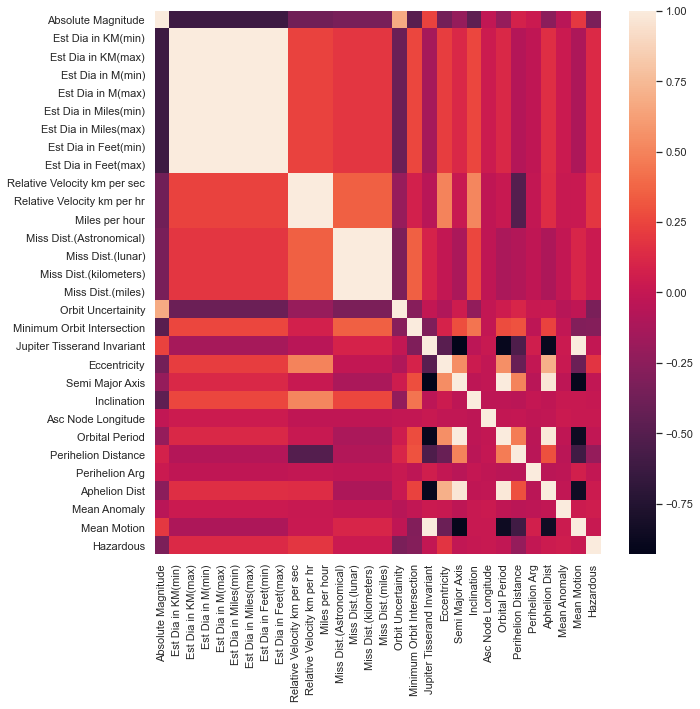

In [7]:
sns.set(style='darkgrid')
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr())
plt.show()

### Takeaways
- Min and max estimated diameter have measured in several units like Km, m, Miles, and Feet. 
- All the variables shows a perfect correlation to each other. 
- We can keep one variable to measure the estimated diameter. 
- So we are going to keep 'Est Dia in KM(min)'.
- Relative velocity has also measured in three different units they are perfectly correlated to each other.
- We are going to keep 'Relative Velocity km per hr'
- 'Miss Dist.' also has shows same charecteristics as above two. So, we are going to keep 'Miss Dist.(kilometers)'

In [8]:
# drop the mentioned variables from the dataset
df = df.drop(['Est Dia in KM(max)','Est Dia in M(min)','Est Dia in M(max)','Est Dia in Miles(min)','Est Dia in Miles(max)','Est Dia in Feet(min)','Est Dia in Feet(max)',
             'Relative Velocity km per sec','Miles per hour',
             'Miss Dist.(Astronomical)','Miss Dist.(lunar)','Miss Dist.(miles)'],axis = 1)
print(df.shape)
df.head()

(4687, 18)


,Absolute Magnitude,Est Dia in KM(min),Relative Velocity km per hr,Miss Dist.(kilometers),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Mean Anomaly,Mean Motion,Hazardous
0,21.6,0.127220,22017.003799,62753692.0,5,0.025282,4.634,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,264.837533,0.590551,True
1,21.3,0.146068,65210.346095,57298148.0,3,0.186935,5.457,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,173.741112,0.845330,False
2,20.3,0.231502,27326.560182,7622911.5,0,0.043058,4.557,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,292.893654,0.559371,True
3,27.4,0.008801,40225.948191,42683616.0,6,0.005512,5.093,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,68.741007,0.700277,False
4,21.6,0.127220,35426.991794,61010824.0,1,0.034798,5.154,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,135.142133,0.726395,True


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Absolute Magnitude           4687 non-null   float64
 1   Est Dia in KM(min)           4687 non-null   float64
 2   Relative Velocity km per hr  4687 non-null   float64
 3   Miss Dist.(kilometers)       4687 non-null   float64
 4   Orbit Uncertainity           4687 non-null   int64  
 5   Minimum Orbit Intersection   4687 non-null   float64
 6   Jupiter Tisserand Invariant  4687 non-null   float64
 7   Eccentricity                 4687 non-null   float64
 8   Semi Major Axis              4687 non-null   float64
 9   Inclination                  4687 non-null   float64
 10  Asc Node Longitude           4687 non-null   float64
 11  Orbital Period               4687 non-null   float64
 12  Perihelion Distance          4687 non-null   float64
 13  Perihelion Arg    

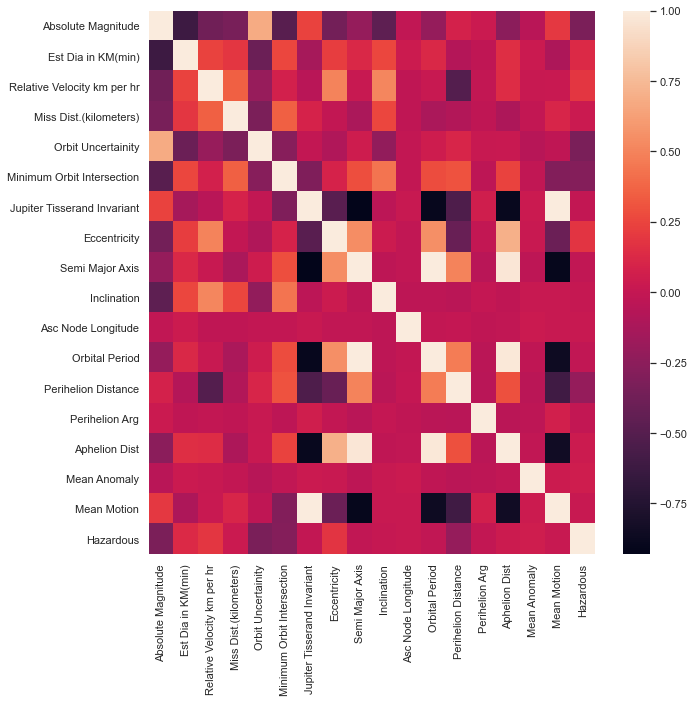

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr())
plt.show()

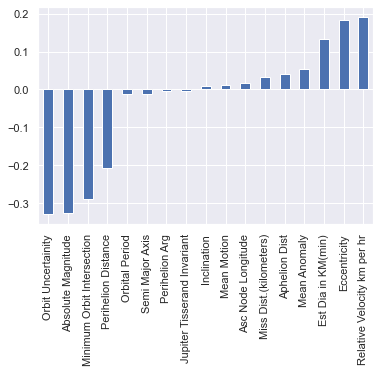

In [11]:
# To get a more clear picture of the correlation with Hazardous Nature
df.corr()['Hazardous'][:-1].sort_values().plot(kind='bar')
plt.show()

### Exploratory Data Analysis
#### Hazardous Nature
Is the asteroid hazardous? (True or False)

False    3932
True      755
Name: Hazardous, dtype: int64




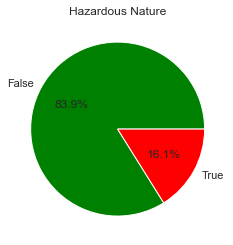

In [12]:
# get the values
print(df['Hazardous'].value_counts())
print('\n')

# plot
lab = 'False','True'
plt.pie(df['Hazardous'].value_counts(), labels = lab, colors = ['green','red'],
        autopct='%1.1f%%')
plt.title('Hazardous Nature')
plt.show()

The datset contains 16.1% of hazardous asteroids and 83.9% of non-hazardous asteroids.

____

#### Orbit Uncertainity
A measure of the uncertainty ('measurement errors') in the calculated orbit

In [13]:
# get the values
print(df['Orbit Uncertainity'].value_counts())
print('\n')

# plot
df1 = df.groupby(["Orbit Uncertainity"]).count().reset_index()

fig = px.bar(df1,
             y=df.groupby(["Orbit Uncertainity"]).size()/len(df)*100,
             x="Orbit Uncertainity")
fig.update_layout(yaxis_title='percentage',
                  title_text='Orbit Uncertainity')
fig.show()

0    1353
7     700
6     620
1     568
8     329
5     321
2     279
4     212
3     182
9     123
Name: Orbit Uncertainity, dtype: int64




Orbit Uncertainity vs. Hazardous Nature

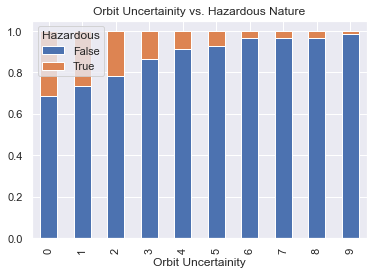

In [14]:
# plot
df.groupby('Orbit Uncertainity')['Hazardous'].value_counts(normalize=True).unstack('Hazardous').plot.bar(stacked=True, title='Orbit Uncertainity vs. Hazardous Nature')
plt.show()

Absolute Magnitude

Measure of the luminosity of an asteroid, on an inverse logarithmic astronomical magnitude scale.

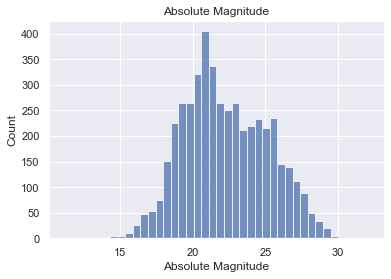

In [15]:
# plot
sns.histplot(data['Absolute Magnitude']).set_title('Absolute Magnitude')
plt.show()

Absolute Magnitude vs. Hazardous Nature

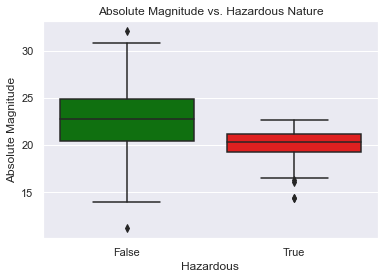

In [16]:
# plot
sns.boxplot(x="Hazardous", y="Absolute Magnitude",data=df,palette=('green','red')).set_title('Absolute Magnitude vs. Hazardous Nature')
plt.show()

Minimum Orbit Intersection

The closest distance between Earth and the asteroid in their respective orbits (in astronomical units)

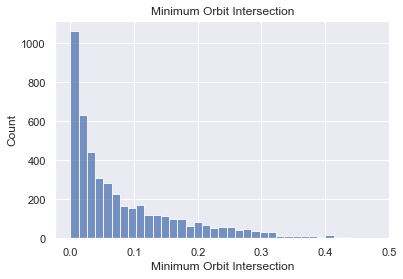

In [17]:
# plot
sns.histplot(data['Minimum Orbit Intersection']).set_title('Minimum Orbit Intersection')
plt.show()

Minimum Orbit Intersection vs. Hazardous Nature

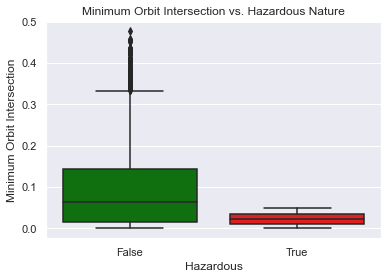

In [18]:
# plot
sns.boxplot(x="Hazardous", y="Minimum Orbit Intersection",data=df,palette=('green','red')).set_title('Minimum Orbit Intersection vs. Hazardous Nature')
plt.show()

Perihelion Distance

Distance of point in asteroid's orbit which is closest to the Sun

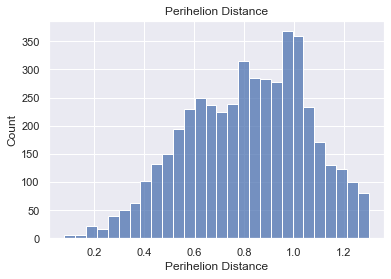

In [19]:
# plot
sns.histplot(data['Perihelion Distance']).set_title('Perihelion Distance')
plt.show()

Perihelion Distance vs. Hazardous Nature

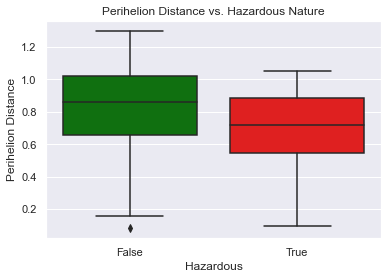

In [20]:
# plot
sns.boxplot(x="Hazardous", y="Perihelion Distance",data=df,palette=('green','red')).set_title('Perihelion Distance vs. Hazardous Nature')
plt.show()

Est Dia in KM (min)

Minimum estimated diameter of the asteroid

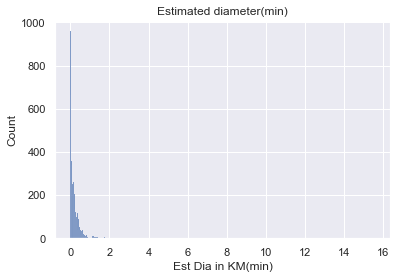

In [21]:
# plot
sns.histplot(data['Est Dia in KM(min)']).set_title('Estimated diameter(min)')
plt.show()

Est Dia in KM(min) vs. Hazardous Nature

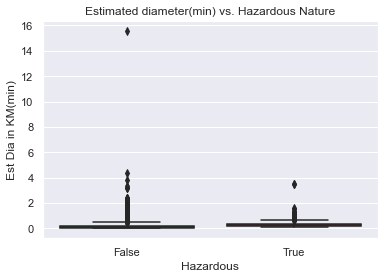

In [22]:
# plot
sns.boxplot(x="Hazardous", y="Est Dia in KM(min)",data=df,palette=('green','red')).set_title('Estimated diameter(min) vs. Hazardous Nature')
plt.show()

Eccentricity

A value which specifies by how much the asteroid's orbit deviates from a perfect circle

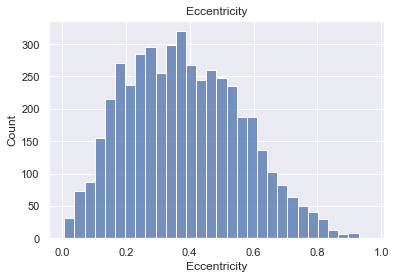

In [23]:
# plot
sns.histplot(data['Eccentricity']).set_title('Eccentricity')
plt.show()

Eccentricity vs. Hazardous Nature

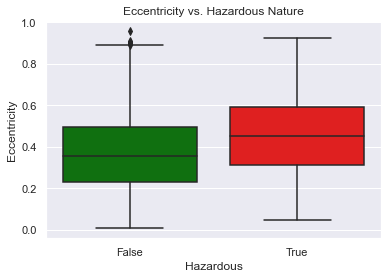

In [24]:
# plot
sns.boxplot(x="Hazardous", y="Eccentricity",data=df,palette=('green','red')).set_title('Eccentricity vs. Hazardous Nature')
plt.show()

Relative Velocity

Asteroid's velocity relative to earth

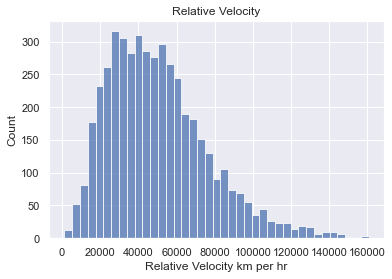

In [25]:
# plot
sns.histplot(data['Relative Velocity km per hr']).set_title('Relative Velocity')
plt.show()

Relative Velocity vs. Hazardous Nature

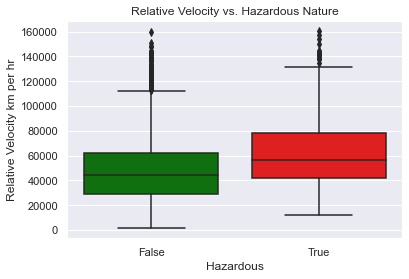

In [26]:
# plot
sns.boxplot(x="Hazardous", y="Relative Velocity km per hr",data=df,palette=('green','red')).set_title('Relative Velocity vs. Hazardous Nature')
plt.show()

### Advanced Analysis


Let's separate the variable of interest as the response variable and all the other variables as the predictor variables.